In [1]:
import sys
sys.path.append("..")

In [2]:
import copy
from io import StringIO     # for converting DataFrames to MonroeDataEntry lists
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # for reading CSV

from color_eval_utils import normalize, flatten
from color_eval_utils import plot_score_dists
from color_eval_utils import NgramMetrics, ListenerMetrics
from monroe_data import MonroeData, MonroeDataEntry, Color # stores data

%matplotlib inline

# 1. Load in Data
All of the data from our experiments is in the file "clean_data.csv" in the data/csv directory. This includes both the data we collected and the entries from the Monroe et al., 2017 data we used.

Rows:
- Each row is an entry containing information about a single listener's color selection given a set of three colors and a candidate caption.

Columns:
- __contextId__: Of the form ci{id}.{flipped}
    - id: indicates which group of three colors are in the context. (ranges from 0 to 179)
    - flipped: 0 the target color is the same as in the Monroe dataset (unflipped), and 1 if the Monroe distr1 is the target instead (flipped). These two conditions let us calculate scores for misleading captions.
- __contextNum__: Identifies a unique caption within the entries with the same contextId. Our data have contextNums from 0 to 9, monroe data is 10 and above.
- __condition__: Color distances from Monroe data: close, split, or far
- __quality__: Whether the speakers generating the captions were instructed to be descriptive or ambiguous (descriptive, ambiguous)
- __clickStatus__, __alt1Status__, __alt2Status__: Indicates which color the listener clicked on, and which ones they did not: (target, distr1, distr2)
- __clickColH__, __clickColS__, __clickColL__, __alt1ColH__, __alt1ColS__, __alt1ColL__, __alt2ColH__, __alt2ColS__, __alt2ColL__: The HSL values for the color the listener clicked on and the alternate colors
- __clickLocS__, __clickalt1S__, __clickalt2S__: Where the speaker saw each of the colors when generating the caption. Target was always on the left in postition 0. Positions are numbered from left to right, 0, 1, 2
- __clickLocL__, __clickalt1L__, __clickalt2L__: Where the listener saw each of the colors when trying to identify the target.
- __targetD1Diff__, __targetD2Diff__, __D1D2Diff__: CIEDE2000 color differecnes between the target and distractors.
- __outcome__: True if the listener chose the target, false otherwise
- __contents__: The candidate caption the listener saw.


For the data we collect, we had three humans play the listener role with each speaker utterance, so our data has three entries with the same contextId, contextNum pair. For the Monroe Data, there is only one listener, so there is only one entry with the contextId, contextNum pair.

Also note that we did not collect human listener data for all of the ambiguous candidates. Some of these ambiguous candidates were also among the descriptive candidates for their contexts, so we did not collect the same data twice. (Because these captions are descriptive, they are also not ambiguous so we do not include them in our ambiguous candidates in our analysis). They are indicated by rows with NaN values.

In [3]:
# We set single_speaker to false to not do any Monroe et al-specific preprocessing
all_data = MonroeData("../data/csv/clean_data.csv", single_speaker=False)

# 2. Separate Data

We separate the data along two axis:
1. Descriptive vs. Ambiguous: Whether the speaker was attempting to distinguish the target from the distractors (descriptive) or was trying to make it difficult for listeners to choose the target by generating a vague, but true description (ambiguous)
2. Unflipped vs. Flipped: Whether the target is the same as in the Monroe data (unflipped) or Distractor 1 is the target (flipped)


In [4]:
# Descriptive vs. Ambiguous
desc_all = all_data.data[all_data.data['quality'] == "descriptive"].dropna()
ambi_all = all_data.data[all_data.data['quality'] == "ambiguous"].dropna()

In [5]:
# Unflipped vs. Flipped
desc_unflipped_all = desc_all[desc_all['contextId'].str.contains(".0", regex=False)]
desc_flipped_all = desc_all[desc_all['contextId'].str.contains(".1", regex=False)]

ambi_unflipped_all = ambi_all[ambi_all['contextId'].str.contains(".0", regex=False)]
ambi_flipped_all = ambi_all[ambi_all['contextId'].str.contains(".1", regex=False)]

Some of the data above has three rows for the same context, but to use our n-gram overlap and listener-based metrics, we only want to count each context once. When we look at human evaluation and filtering we will come back to using all three contexts, as they have potentially different listener selections.

In [6]:
# These include only one of the listener's responses
desc_unflipped = desc_unflipped_all.groupby(['contextId', 'contextNum']).first().reset_index()
desc_flipped = desc_flipped_all.groupby(['contextId', 'contextNum']).first().reset_index()

ambi_unflipped = ambi_unflipped_all.groupby(['contextId', 'contextNum']).first().reset_index()
ambi_flipped = ambi_flipped_all.groupby(['contextId', 'contextNum']).first().reset_index()

It's also easier to deal with a list of entries rather than raw Pandas DataFrame rows. Each entry is a MonroeDataEntry object.

In [7]:
# turn dataframes into context lists
def df_to_ctxs(df):
    """Convert a pandas dataframe into a list of MonroeDataEntries"""
    # This is going to be a bit unconventional, but we're just going
    # to instantiate these MonroeData objects with no data, place the
    # passed df into where the data should go, and create MonroeEntries
    # from that df.
    md = MonroeData(StringIO(",".join(df.columns)), # pd.read_csv needs columns
                    single_speaker=False)           # don't do any fancy filtering
    md.data = df
    for _ in md.read_data(): pass
    return md.entries

In [8]:
%%time 
# ~ 14 s
desc_unflipped_ctxs = df_to_ctxs(desc_unflipped)
desc_flipped_ctxs = df_to_ctxs(desc_flipped)

ambi_unflipped_ctxs = df_to_ctxs(ambi_unflipped)
ambi_flipped_ctxs = df_to_ctxs(ambi_flipped)

CPU times: user 15.1 s, sys: 108 ms, total: 15.2 s
Wall time: 15.2 s


# 3. Filter Data

Before we evaluate these candidate captions with n-gram overlap or listener metrics, we have to do a little bit of filtering.
1. __Descriptive__: Remove any candidates that led 2/3 of human listeners to the wrong the target.
2. __Ambiguous__: Remove any candidates that are in the list of descriptive candidates that remain. (This was already mostly done before, but was not done with the Monroe dataset's descriptive candidates in this descrtiptive candidate list).
3. __Misleading__: First, generate the misleading data by swapping the colors from the descriptive flipped contexts to the descriptive unflipped contexts and vice versa. Then remove candiates whose captions are in the set of descriptive captions AND all of the colors are far from each other(this is certainly not necessary, it removes a total of 3 contexts, but is needed to replicate the paper's results).


All of this filtering happens at the context level, so first we are going to convert a list of contexts, into a list of lists of contexts where each context list contains all of the contexts with the same colors and targets.

In [9]:
def group_contexts(df, ctx_list):
    """Turn list of contexts into list of lists of contexts with the same colors"""
    
    # assumes ctx_list is in the same order as df rows
    
    # count how many of each contextId we have
    df_counts = df.groupby('contextId')['contextId'].transform("count")
    grouped_ctx_list = []

    # reshape ctx_list into list of lists. Outer list will have one list for each
    # contextId, and each sublist will hold all of the contexts.
    count = df_counts[0]
    i = count
    total = i
    group = []
    for ctx in ctx_list:
        if count == 0:
            count = df_counts[i]
            i += count
            total += count
            grouped_ctx_list.append(group)
            group = []

        group.append(ctx)
        count -= 1
    
    grouped_ctx_list.append(group)
    return grouped_ctx_list

In [10]:
# group our four categories
desc_unflipped_ctxs_grouped = group_contexts(desc_unflipped, desc_unflipped_ctxs)
desc_flipped_ctxs_grouped = group_contexts(desc_flipped, desc_flipped_ctxs)

ambi_unflipped_ctxs_grouped = group_contexts(ambi_unflipped, ambi_unflipped_ctxs)
ambi_flipped_ctxs_grouped = group_contexts(ambi_flipped, ambi_flipped_ctxs)

In [11]:
# get misleading captions (note we are using the descriptive candiates BEFORE filtering. This is
# to replicate the exact results reported in the paper)
def desc_to_misl(desc_ctx_caption, desc_ctx_color):
    """Convert the good contexts to an ugly one using one for the caption and one for the colors"""
    misl_ctx = copy.deepcopy(desc_ctx_caption)

    for i in range(len(misl_ctx)):
        for j in range(len(misl_ctx[i])):
            misl_ctx[i][j].colors = copy.copy(desc_ctx_color[i][0].colors)
            
    return misl_ctx

misl_unflipped_ctxs_grouped = desc_to_misl(desc_flipped_ctxs_grouped, desc_unflipped_ctxs_grouped)
misl_flipped_ctxs_grouped = desc_to_misl(desc_unflipped_ctxs_grouped, desc_flipped_ctxs_grouped)

In [12]:
# filtering
def filter_desc(desc_df, desc_ctxs):
    """Keeps only captions that led at least 2/3 of listeners to the target"""
    desc_ctx_groups = [] # holds filtered contexts
    
    # create boolean list indicating if at least 2/3 listeners chose correctly
    desc_df_grouped = desc_df.groupby(['contextId', 'contextNum'])
    desc_df_ml = desc_df_grouped.apply(lambda x: (x['clickStatus'] == "target").mean() >= 2/3)
    
    # filter desc_ctxs according to boolean list
    for i, context_id in enumerate(desc_df_ml.index.levels[0]):
        desc_ctx_group = []
        for j, majority_correct in enumerate(desc_df_ml[context_id]):
            if majority_correct:
                desc_ctx_group.append(desc_ctxs[i][j])
        desc_ctx_groups.append(desc_ctx_group)
    return desc_ctx_groups

def filter_ambi(contexts, refs):
    """Filters ambiguous captions that are in their reference sets"""
    ambi_ctx_groups = []
    for i, ctx_group in enumerate(contexts):
        ref_caps = [normalize(ctx.caption) for ctx in refs[i]]
        abmi_ctx_group = [ctx for ctx in ctx_group if normalize(ctx.caption) not in ref_caps]
        ambi_ctx_groups.append(abmi_ctx_group)
    return ambi_ctx_groups

def filter_misl(df, contexts, refs):
    """Filters misleading captions the same way as the descriptive 
       ones and remove ones with captions in the references in the far condition"""
    contexts = filter_desc(df, contexts)
    misl_ctx_groups = []
    for i, ctx_group in enumerate(contexts):
        ref_caps = [normalize(ctx.caption) for ctx in refs[i]]
        misl_ctx_group = []
        for ctx in ctx_group:
            if not (normalize(ctx.caption) in ref_caps and ctx.condition == "far"):
                misl_ctx_group.append(ctx)
        misl_ctx_groups.append(misl_ctx_group)
    return misl_ctx_groups

In [13]:
# descriptive filtering
desc_unflipped_ctxs_grouped = filter_desc(desc_unflipped_all, desc_unflipped_ctxs_grouped)
desc_flipped_ctxs_grouped = filter_desc(desc_flipped_all, desc_flipped_ctxs_grouped)

# ambiguous filtering
ambi_unflipped_ctxs_grouped = filter_ambi(ambi_unflipped_ctxs_grouped, desc_unflipped_ctxs_grouped)
ambi_flipped_ctxs_grouped = filter_ambi(ambi_flipped_ctxs_grouped, desc_flipped_ctxs_grouped)

# misleading filtering
misl_unflipped_ctxs_grouped = filter_misl(desc_flipped_all, misl_unflipped_ctxs_grouped, desc_unflipped_ctxs_grouped)
misl_flipped_ctxs_grouped = filter_misl(desc_unflipped_all, misl_flipped_ctxs_grouped, desc_flipped_ctxs_grouped)

# N-Gram Overlap Metrics

Finally, we can calculate some metrics. We use BLEU, ROUGE-L, METEOR, and CIDEr. All of these require reference captions, so we use our filtered and grouped descriptive candidates as references. Then we calculate and plot our overlap metric scores.

In [14]:
# generate references
def extract_captions(ctx_list):
    """Converts list of contexts to list of string captions"""
    # if we have a list of lists, flatten it first
    if type(ctx_list[0]) is list:
        ctx_list = flatten(ctx_list)
    return [normalize(ctx.caption) for ctx in ctx_list]

def extract_references(reference_ctxs, candidate_ctxs=None):
    """Uses reference_ctxs to create a list of reference captions for each candidate in candiate_ctxs"""
    references = []
    if candidate_ctxs is None:
        # generate references in leave-one out style (for descriptive references only)
        for i in range(len(reference_ctxs)):
            if len(reference_ctxs[i]) == 1:
                # if there's only one caption, let it be its own reference
                references.append(extract_captions(reference_ctxs[i]))
                continue
            for j in range(len(reference_ctxs[i])):
                refs = reference_ctxs[i][:j] + reference_ctxs[i][j+1:]
                references.append(extract_captions(refs))

    else:
        # generate references using all captions in reference_ctxs (for ambiguous and misleading references)
        for i in range(len(candidate_ctxs)): # same as len(reference_ctxs)
            for j in range(len(candidate_ctxs[i])):
                references.append(extract_captions(reference_ctxs[i]))

    return references

In [15]:
# unflipped contexts
desc_unflipped_captions = extract_captions(desc_unflipped_ctxs_grouped)
desc_unflipped_references = extract_references(desc_unflipped_ctxs_grouped)

ambi_unflipped_captions = extract_captions(ambi_unflipped_ctxs_grouped)
ambi_unflipped_references = extract_references(desc_unflipped_ctxs_grouped, ambi_unflipped_ctxs_grouped)

misl_unflipped_captions = extract_captions(misl_unflipped_ctxs_grouped)
misl_unflipped_references = extract_references(desc_unflipped_ctxs_grouped, misl_unflipped_ctxs_grouped)

In [16]:
# flipped contexts
desc_flipped_captions = extract_captions(desc_flipped_ctxs_grouped)
desc_flipped_references = extract_references(desc_flipped_ctxs_grouped)

ambi_flipped_captions = extract_captions(ambi_flipped_ctxs_grouped)
ambi_flipped_references = extract_references(desc_flipped_ctxs_grouped, ambi_flipped_ctxs_grouped)

misl_flipped_captions = extract_captions(misl_flipped_ctxs_grouped)
misl_flipped_references = extract_references(desc_flipped_ctxs_grouped, misl_flipped_ctxs_grouped)

In [17]:
# run n-gram metrics:
ngram_metrics = NgramMetrics()

In [18]:
%%time
desc_ngram_scores = ngram_metrics.get_overlap_scores(desc_unflipped_references + desc_flipped_references,
                                                     desc_unflipped_captions + desc_flipped_captions)
ambi_ngram_scores = ngram_metrics.get_overlap_scores(ambi_unflipped_references + ambi_flipped_references,
                                                     ambi_unflipped_captions + ambi_flipped_captions)
misl_ngram_scores = ngram_metrics.get_overlap_scores(misl_unflipped_references + misl_flipped_references,
                                                     misl_unflipped_captions + misl_flipped_captions)

CPU times: user 2.34 s, sys: 67.9 ms, total: 2.41 s
Wall time: 15.2 s


Now we can visualize stuff with the plots and check our correlations

Pearson r: -0.363, p = 0.000
Spearman r: -0.349, p = 0.000
Kendall τ: -0.290, p = 0.000


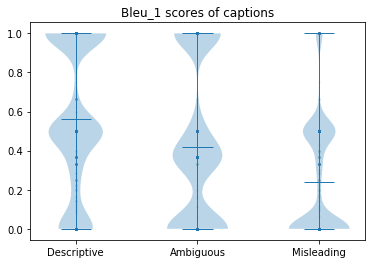

Pearson r: -0.441, p = 0.000
Spearman r: -0.439, p = 0.000
Kendall τ: -0.378, p = 0.000


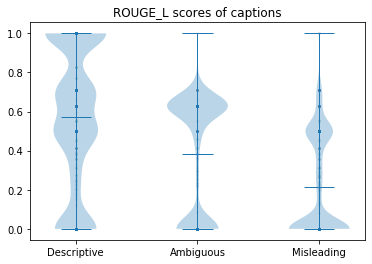

Pearson r: -0.482, p = 0.000
Spearman r: -0.479, p = 0.000
Kendall τ: -0.404, p = 0.000


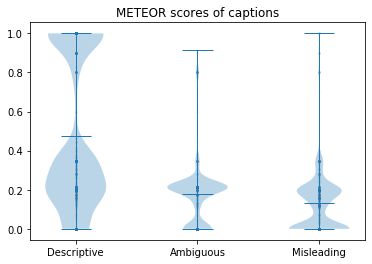

Pearson r: -0.398, p = 0.000
Spearman r: -0.413, p = 0.000
Kendall τ: -0.337, p = 0.000


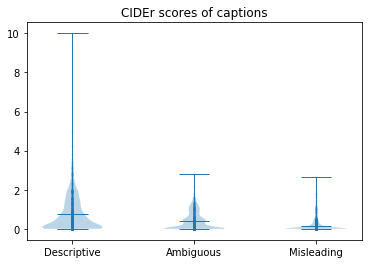

In [19]:
plot_score_dists(desc_ngram_scores, ambi_ngram_scores, misl_ngram_scores)

CIDEr's scores are the only ones that are different here because we use all of the captions in that condition (descriptive, ambiguous, misleading) for calculating the IDF. This difference is small: 0.398 in the combined condition, 0.403 in the separate flipped/unflipped condition. The combined way is a little cleaner, so we report it here.

# Listener Evaluation
Now we can use the models that we created to assess the candidate captions.

In [20]:
listener_metrics = ListenerMetrics()

In [ ]:
%%time
# now run the evaluation - takes about a minute
desc_listener_scores = listener_metrics.get_listener_scores(flatten(desc_unflipped_ctxs_grouped) + flatten(desc_flipped_ctxs_grouped))
ambi_listener_scores = listener_metrics.get_listener_scores(flatten(ambi_unflipped_ctxs_grouped) + flatten(ambi_flipped_ctxs_grouped))
misl_listener_scores = listener_metrics.get_listener_scores(flatten(misl_unflipped_ctxs_grouped) + flatten(misl_flipped_ctxs_grouped))

In [ ]:
plot_score_dists(desc_listener_scores, ambi_listener_scores, misl_listener_scores, metrics=["Literal Listener", "Pragmatic Listener"])

# Human Listener Evaluation

Finally, we can use the same human listeners we used to do the filtering to get a sense of how human behaviour would correlate with these quality categories.

This section is a little different from the other two because we don't use any of the Monroe et al., 2017 data. The subset of their data that we used was chosen, among other criteria, because the Human Listeners were able to correctly identify the target*. As such, we do not include it in our human listener approximation. Also, in the previous sections we only used one caption per context, but here we have three listener's responses to each context, so we use all of them. 

Because of this, we deal directly with the original pandas dataframes we generated, and perform the filtering again on the dataframes themselves. (The misleading filtering is not included because when there are no monroe captions, it has no effect.)


*Other criteria were it was in the Dev set and there were multiple colors that were close together all within the same Monroe et al. condition (e.g. close, split, far)

In [23]:
%%time
# do the 2/3 filtering on the dataframe:
def filter_desc_df(desc_df):
    desc_grouped = desc_df.groupby(["contextId", "contextNum"])
    desc_approved = desc_grouped.filter(lambda x: (x['clickStatus'] == 'target').mean() >= 2/3)
    return desc_approved

# remove monroe data - context num >= 10 goes away
desc_unflipped_newman = filter_desc_df(desc_unflipped_all[desc_unflipped_all['contextNum'] < 10])
desc_flipped_newman = filter_desc_df(desc_flipped_all[desc_flipped_all['contextNum'] < 10])

CPU times: user 928 ms, sys: 4.32 ms, total: 932 ms
Wall time: 934 ms


In [24]:
%%time
def filter_ambi_df(contextIds, captions, desc_approved):
    """ filter out ambiguous captions that overlap with descriptive ones"""
    # all of the contextIds and captions are identical, so just take the first one.
    contextId = contextIds.iloc[0]
    caption = captions.iloc[0]
    desc_captions = desc_approved[desc_approved["contextId"] == contextId]["contents"]
    desc_captions = [normalize(desc_caption) for desc_caption in desc_captions]
    return normalize(caption) not in desc_captions

desc_unflipped_approved = filter_desc_df(desc_unflipped_all)
desc_flipped_approved = filter_desc_df(desc_flipped_all)

CPU times: user 1.17 s, sys: 6.22 ms, total: 1.18 s
Wall time: 1.18 s


In [25]:
ambi_unflipped_newman = ambi_unflipped_all.groupby(["contextId", "contextNum"]).filter(
    lambda x: filter_ambi_df(x['contextId'], x['contents'], desc_unflipped_approved
                            ))
ambi_flipped_newman = ambi_flipped_all.groupby(["contextId", "contextNum"]).filter(
    lambda x: filter_ambi_df(x['contextId'], x['contents'], desc_flipped_approved
                            ))

In [26]:
# "calculate" scores
def get_human_listener_scores(*dfs):
    score_report = {}
    scores = []
    for df in dfs:
        scores.extend([1 if clicked_target else 0 for clicked_target in df['outcome']])
    return {
        "Human Listener": (np.mean(scores), scores)
    }


In [27]:
desc_human_scores = get_human_listener_scores(desc_unflipped_newman, desc_flipped_newman)
ambi_human_scores = get_human_listener_scores(ambi_unflipped_newman, ambi_flipped_newman)

The targets in the flipped conditions are distractor 1 ("distr1") in the unflipped condition, so we're only going to say that the listener was correct in the misleading scenario if they chose distr1. (This is slightly more correct than what we reported in the original paper where we say if a listener chose the incorrect color in the descriptive case then they chose the correct color in the misleading case).

In [28]:
# See text above for explanation of what is going on in this cell.
misl_human_scores = []

for i in range(len(desc_human_scores['Human Listener'][1])):
    if not desc_human_scores['Human Listener'][1][i]:
        # incorrect in descriptive: check which distractor was selected
        if i < len(desc_unflipped_newman): # flipped
            misl_human_scores.append(int(desc_unflipped_newman.iloc[i]["clickStatus"] == "distr1"))
        else: # unflipped
            misl_human_scores.append(int(desc_flipped_newman.iloc[i - len(desc_unflipped_newman)]["clickStatus"] == "distr1"))
    else:
        misl_human_scores.append(0) # correct in descriptive means incorrect in misleading
        
misl_human_scores = {
    'Human Listener': (np.mean(misl_human_scores), misl_human_scores)
}       

Pearson r: -0.722, p = 0.000
Spearman r: -0.722, p = 0.000
Kendall τ: -0.681, p = 0.000


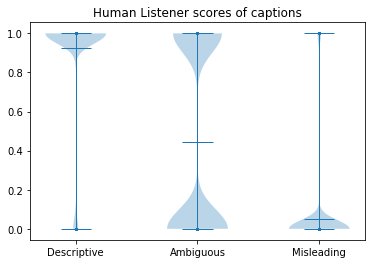

In [29]:
plot_score_dists(desc_human_scores, ambi_human_scores, misl_human_scores, metrics=['Human Listener'])

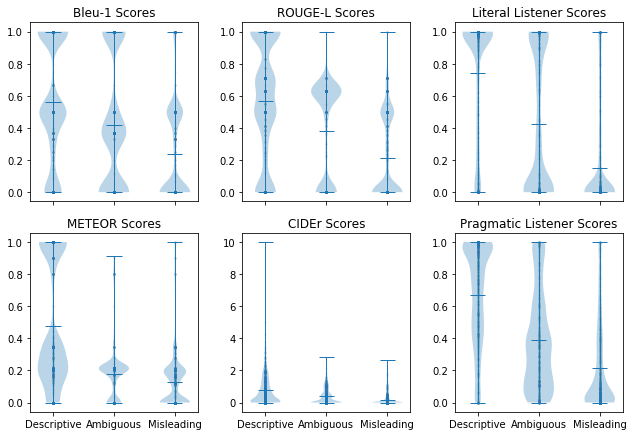

In [43]:
# Now let's make the same gridded plot in the paper
all_scores = [{**desc_ngram_scores, **desc_listener_scores},
              {**ambi_ngram_scores, **ambi_listener_scores},
              {**misl_ngram_scores, **misl_listener_scores}
             ]
for i in range(len(all_scores)):
    all_scores[i]['Bleu-1'] = all_scores[i]['Bleu_1']
    all_scores[i]['ROUGE-L'] = all_scores[i]['ROUGE_L']

all_metrics = ['Bleu-1', 'METEOR', 'ROUGE-L', 'CIDEr', 'Literal Listener', 'Pragmatic Listener']

mc = 0
fig, axes = plt.subplots(2, 3, sharex=True, figsize=(9, 6))
fig.tight_layout()
fig.subplots_adjust(hspace=0.175)
for i in range(3):
    for j in range(2):
        metric = all_metrics[mc]
        plot_data = [score[metric][1] for score in all_scores]
        point_data = [np.repeat(i+1, len(s)) for i, s in enumerate(plot_data)]
        vpdata = axes[j, i].violinplot(plot_data, showmeans=True, bw_method=0.2, showextrema=True)
        vpdata["cbars"].set(linewidths=1)
        vpdata["cmeans"].set(linewidths=1)
        vpdata["cmins"].set(linewidths=1)
        vpdata["cmaxes"].set(linewidths=1)
        
        scatter_data_x = []
        scatter_data_y = []
        for k in range(3):
            scatter_data_x.extend(point_data[k])
            scatter_data_y.extend(plot_data[k])
        axes[j, i].scatter(scatter_data_x, scatter_data_y, alpha=0.01, s=5)
        axes[j, i].xaxis.set_ticks([1, 2, 3])
        axes[j, i].set_xticklabels(["Descriptive", "Ambiguous", "Misleading"])
        axes[j, i].set_title("{} Scores".format(metric))
        mc += 1